# LSTM

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [3]:
#MODEL PARAMETER
DATA_OFFSET     = 1                                                 # data preprocess offset
INPUT_SIZE      = 1                                                 # the number of input data feature
NUM_LAYERS      = 2                                                 # staked RNN
HIDDEN_SIZE     = 8                                                 # hidden layer 8
NUM_CLASSES     = 1                                                 # the number of output data feature

# HYPER PARAMETER
SEQ_LEN         = 20                                                # sequence length
BATCH_SIZE      = 10974                                             # batch size
CRITERION       = nn.MSELoss()                                      # mean square error
LEARNING_RATE   = 1e-3                                              # learning rate
NUM_EPOCHS      = 60                                                # epoch

#DATA PARAMETER
TRAIN_NUM       = 60                                                # train number
TEST_NUM        = 20                                                # test number
DATASET_NUM     = TRAIN_NUM + TEST_NUM + DATA_OFFSET                # dataset number

# HYPER PARAMETER
SPLIT_SET_NUM   = 3                                                 # split set number = 3 -> test: 3 set
SET_NUM         = 10974                                             # set size
TEST_SIZE       = SET_NUM * SPLIT_SET_NUM                           # test size
SPLIT           = SET_NUM * DATASET_NUM - TEST_SIZE                 # plot test number

# Data Padding

data가 반복되기 때문에 앞에 data를 padding 하는 것이 올바른 방안이라고 생각

In [7]:
df = pd.read_table(f'C:/Users/DCLAB/Desktop/output/output_{1}.csv', sep=',')
df = df.fillna(0)
df.columns = ["sequence","inter_x","inter_y","distance","block_x","block_y","is_block",
            "attenuated","attenuation_factor","change_val","Realized_Power","Real_block"]
df = df.drop(['sequence'], axis=1)
df = df.drop(['inter_x'], axis=1)
df = df.drop(['inter_y'], axis=1)
df = df.drop(['distance'], axis=1)
df = df.drop(['block_x'], axis=1)
df = df.drop(['block_y'], axis=1)
df = df.drop(['is_block'], axis=1)
df = df.drop(['attenuated'], axis=1)
df = df.drop(['attenuation_factor'], axis=1)
df = df.drop(['change_val'], axis=1)
#df = df.drop(['Realized_Power'], axis=1)
df = df.astype('float')
pl = df

for i in range(2, 80):
    df = pd.read_table(f'C:/Users/DCLAB/Desktop/output/output_{i}.csv', sep=',')
    df = df.fillna(0)
    df.columns = ["sequence","inter_x","inter_y","distance","block_x","block_y","is_block",
                "attenuated","attenuation_factor","change_val","Realized_Power","Real_block"]
    df = df.drop(['sequence'], axis=1)
    df = df.drop(['inter_x'], axis=1)
    df = df.drop(['inter_y'], axis=1)
    df = df.drop(['distance'], axis=1)
    df = df.drop(['block_x'], axis=1)
    df = df.drop(['block_y'], axis=1)
    df = df.drop(['is_block'], axis=1)
    df = df.drop(['attenuated'], axis=1)
    df = df.drop(['attenuation_factor'], axis=1)
    df = df.drop(['change_val'], axis=1)
    #df = df.drop(['Realized_Power'], axis=1)
    df = df.astype('float')
    df = pd.concat([df, pl], ignore_index=True)
    pl = df

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cuda:0 is available.


In [9]:
import numpy as np
import torch
import random

# seq_data
def seq_data(x, y, seq_len): # sequence length
    x_seq = []
    y_seq = []
    
    for i in range(len(x)-seq_len-1):
            x_seq.append(x[i:i+seq_len])
            y_seq.append(y[i+seq_len+1])

    x_seq = np.array(x_seq)        
    y_seq = np.array(y_seq)

    return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1, 1]) 

def train_test_seperate(X, y, seq_len, split, batch_size):
    x_seq, y_seq = seq_data(X, y, seq_len)
    x_train_seq = x_seq[:split]
    y_train_seq = y_seq[:split]
    x_test_seq = x_seq[split:]
    y_test_seq = y_seq[split:]

    # Dataset
    train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
    test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

    # Dataloader -> batch_size
    train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [10]:
# Meta learning (Few shot dataset (random: 1 ~ 600,000))
def sample_data(x, y, seq_len ,K):
    x_seq = []
    y_seq = []
    r = random.randint(1, 600000)

    for i in range(r, r + K):
            x_seq.append(x[i:i+seq_len])
            y_seq.append(y[i+seq_len+1])

    x_seq = np.array(x_seq)        
    y_seq = np.array(y_seq)

    return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1, 1]) 

In [11]:
X = pl[["Realized_Power"]].values
y = pl["Real_block"].values

In [12]:
#train, test dataset
train_loader, test_loader = train_test_seperate(X, y, SEQ_LEN, SPLIT ,BATCH_SIZE)

In [13]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

test_features, test_labels = next(iter(test_loader))
print(f"Feature batch shape: {test_features.size()}")
print(f"Labels batch shape: {test_labels.size()}")

Feature batch shape: torch.Size([10974, 20, 1])
Labels batch shape: torch.Size([10974, 1])
Feature batch shape: torch.Size([10953, 20, 1])
Labels batch shape: torch.Size([10953, 1])


In [14]:
def model_training(train_loader, num_epochs, model, criterion, optimizer): 
    loss_graph = []
    n = len(train_loader)

    for epoch in range(num_epochs): # epoch
        running_loss = 0.0  
        
        for i, data in enumerate(train_loader): # batch 
            seq, target = data
            out = model(seq)
            loss = criterion(out, target)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        loss_graph.append(running_loss/n)
        
        if epoch % 10 == 0:
            print('[epoch: %d] loss: %.8f' %(epoch, running_loss/n))
    
    plt.figure(figsize=(20,10))
    plt.plot(loss_graph)

LSTM layer 구현

In [15]:
class LSTMCell(nn.Module) :
    def __init__(self, input_size, hidden_size, bias=True) :
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size, 4*hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 4*hidden_size, bias=bias)
        self.reset_parameters()
        
    def reset_parameters(self) :
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters() :
            w.data.uniform_(-std, std)
            
    def forward(self, x, hidden) :
        hx, cx = hidden
        x = x.view(-1, x.size(1))
        
        gates = self.x2h(x) + self.h2h(hx)
        gates = gates.squeeze()
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, -1)
        
        ingate = F.sigmoid(ingate)          
        forgetgate = F.sigmoid(forgetgate)  
        cellgate = F.tanh(cellgate)         
        outgate = F.sigmoid(outgate)        
        
        cy = torch.mul(cx, forgetgate) + torch.mul(ingate, cellgate)
        hy = torch.mul(outgate, F.tanh(cy))
        
        return (hy, cy)

In [16]:
wt = []
wl = []
class MAMLModel(nn.Module):
    def __init__(self, input_size, hidden_size, seq_len, num_layers, device, num_classes):
        super(MAMLModel, self).__init__()
        self.input_size = input_size
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTMCell(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes) #hidden size per length
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        h0 = Variable(torch.Tensor(torch.zeros(self.num_layers, x.size(0), self.hidden_size))).to(device)
        c0 = Variable(torch.Tensor(torch.zeros(self.num_layers, x.size(0), self.hidden_size))).to(device)

        outs = []
        cn = c0[0,:,:]
        hn = h0[0,:,:]
    
        for seq in range(x.size(1)) :
            hn, cn = self.lstm(x[:, seq, :], (hn, cn))
            outs.append(hn)
        
        out = outs[-1]
        out = self.fc(out)
        out = self.sigmoid(out)
        return out
    
    def parameterised(self, x, weights):
        # #print(weights[0], weights[1], weights[2], weights[3], weights[4], weights[5])

        h_0 = Variable(torch.Tensor(torch.zeros(self.num_layers, x.size(0), self.hidden_size))).to(device)
        c_0 = Variable(torch.Tensor(torch.zeros(self.num_layers, x.size(0), self.hidden_size))).to(device)
        
        outs = []
        c_n = c_0[0,:,:]
        h_n = h_0[0,:,:]

        #print(x.size(1))
        for seq in range(x.size(1)) :
            h_n, c_n = self.lstm(x[:, seq, :], (h_n, c_n)) # a=8, b=2 -> [1, 8], [2, 1]
            outs.append(h_n)

        out = outs[-1]
        
        # (10,  8), (8, 32)
        #x = F.linear(out, weights[1], weights[3])
        # (10, 32), (32, 1)
        #x = F.linear(out, weights[4], weights[5])
        
        # (10, 8), (8, 1)
        x = F.linear(out, weights[4], weights[5])
        # (10, 1)
        
        return x


In [17]:
model = MAMLModel(input_size=INPUT_SIZE, 
                   hidden_size=HIDDEN_SIZE, 
                   seq_len=SEQ_LEN, 
                   num_layers=NUM_LAYERS, 
                   num_classes=NUM_CLASSES, 
                   device=device)

model=model.to(device)

In [18]:
for name, param in enumerate(model.parameters()):
    print(name,param.shape)

0 torch.Size([32, 1])
1 torch.Size([32, 8])
2 torch.Size([32])
3 torch.Size([32])
4 torch.Size([1, 8])
5 torch.Size([1])


### Fewshot dataset -> 작은 dataset 크기 기준

---

1개 MAP --> (T: 100)

현재 batch_size (10974) -> epochs 60 (Train 60, Test 20)

---

2개 MAP --> (T: 200) 

현재 batch_size (10974) -> epochs 60 ~ 170 (Train 170, Test 30)

Train set --> random


---

Few-Shot Dataset (Batch size: 5, 10)



In [19]:
class MAML():
    def __init__(self, model, inner_lr, meta_lr, K=10, inner_steps=1, tasks_per_meta_batch=20):
        
        # important objects
        self.model = model
        self.weights = list(model.parameters()) # the maml weights we will be meta-optimising
        self.criterion = CRITERION
        self.meta_optimiser = torch.optim.Adam(self.weights, meta_lr)
        
        # hyperparameters
        self.inner_lr = inner_lr
        self.meta_lr = meta_lr
        self.K = K
        self.inner_steps = inner_steps # with the current design of MAML, >1 is unlikely to work well 
        self.tasks_per_meta_batch = tasks_per_meta_batch 
        
        # metrics
        self.plot_every = 10
        self.print_every = 10
        self.meta_losses = []
    
    #Fewshot Dataset
    def inner_loop(self):
        # reset inner model to current maml weights
        temp_weights = [w.clone() for w in self.weights]
        X = pl[["Realized_Power"]].values
        y = pl["Real_block"].values
        X, y = sample_data(X, y, SEQ_LEN, self.K)
        #print(X.shape) #10, 20, 1
        #print(len(temp_weights))

        # perform training on data sampled from task
        for step in range(self.inner_steps):
            loss = self.criterion(self.model.parameterised(X, temp_weights), y) / self.K
            # compute grad and update inner loop weights
            grad = torch.autograd.grad(loss, temp_weights, allow_unused=True)
            modified_tuple = tuple(0 if item is None else item for item in grad)
            temp_weights = [w - self.inner_lr * g for w, g in zip(temp_weights, modified_tuple)]
        
        X = pl[["Realized_Power"]].values
        y = pl["Real_block"].values
        X, y = sample_data(X, y, SEQ_LEN, self.K)

        loss = self.criterion(self.model.parameterised(X, temp_weights), y) / self.K
        return loss
    
    def main_loop(self, num_iterations):
        epoch_loss = 0
        
        for iteration in range(1, num_iterations+1):
            # compute meta loss
            meta_loss = 0
            
            for i in range(self.tasks_per_meta_batch):
                meta_loss += self.inner_loop()
            
            # compute meta gradient of loss with respect to maml weights
            meta_grads = torch.autograd.grad(meta_loss, self.weights)
            
            # assign meta gradient to weights and take optimisation step
            for w, g in zip(self.weights, meta_grads):
                w.grad = g
            self.meta_optimiser.step()
                    
            # log metrics
            epoch_loss += meta_loss.item() / self.tasks_per_meta_batch

            # loss < 0.01 stop
            if epoch_loss < 0.005:
                return print("stop iteration: {}", iteration)

            if iteration % self.print_every == 0:
                print("{}/{}. loss: {}".format(iteration, num_iterations, epoch_loss / self.plot_every))
            
            if iteration % self.plot_every == 0:
                self.meta_losses.append(epoch_loss / self.plot_every)
                epoch_loss = 0

In [20]:
maml = MAML(model, inner_lr=0.001, meta_lr=0.001)

In [17]:
maml.main_loop(num_iterations=1000)
# 10, 20, 1

10/1000. loss: 0.04928067028522491
20/1000. loss: 0.05223488479852676
30/1000. loss: 0.048465282022953034
40/1000. loss: 0.04333070963621139
50/1000. loss: 0.035984339267015455
60/1000. loss: 0.03531284689903259
70/1000. loss: 0.027904099524021148
80/1000. loss: 0.023253839313983917
90/1000. loss: 0.024221952408552173
100/1000. loss: 0.025318415313959126
110/1000. loss: 0.024853056818246844
120/1000. loss: 0.023226079195737836
130/1000. loss: 0.024171857088804243
140/1000. loss: 0.02511559098958969
150/1000. loss: 0.024984912276268003
160/1000. loss: 0.02278196051716804
170/1000. loss: 0.022832066416740418
180/1000. loss: 0.02306872546672821
190/1000. loss: 0.023551882654428483
200/1000. loss: 0.023659130334854124
210/1000. loss: 0.02431979715824127
220/1000. loss: 0.02277870416641235
230/1000. loss: 0.02445538237690926
240/1000. loss: 0.024565740376710887
250/1000. loss: 0.02508639603853226
260/1000. loss: 0.02530841797590256
270/1000. loss: 0.02323312163352966
280/1000. loss: 0.02284

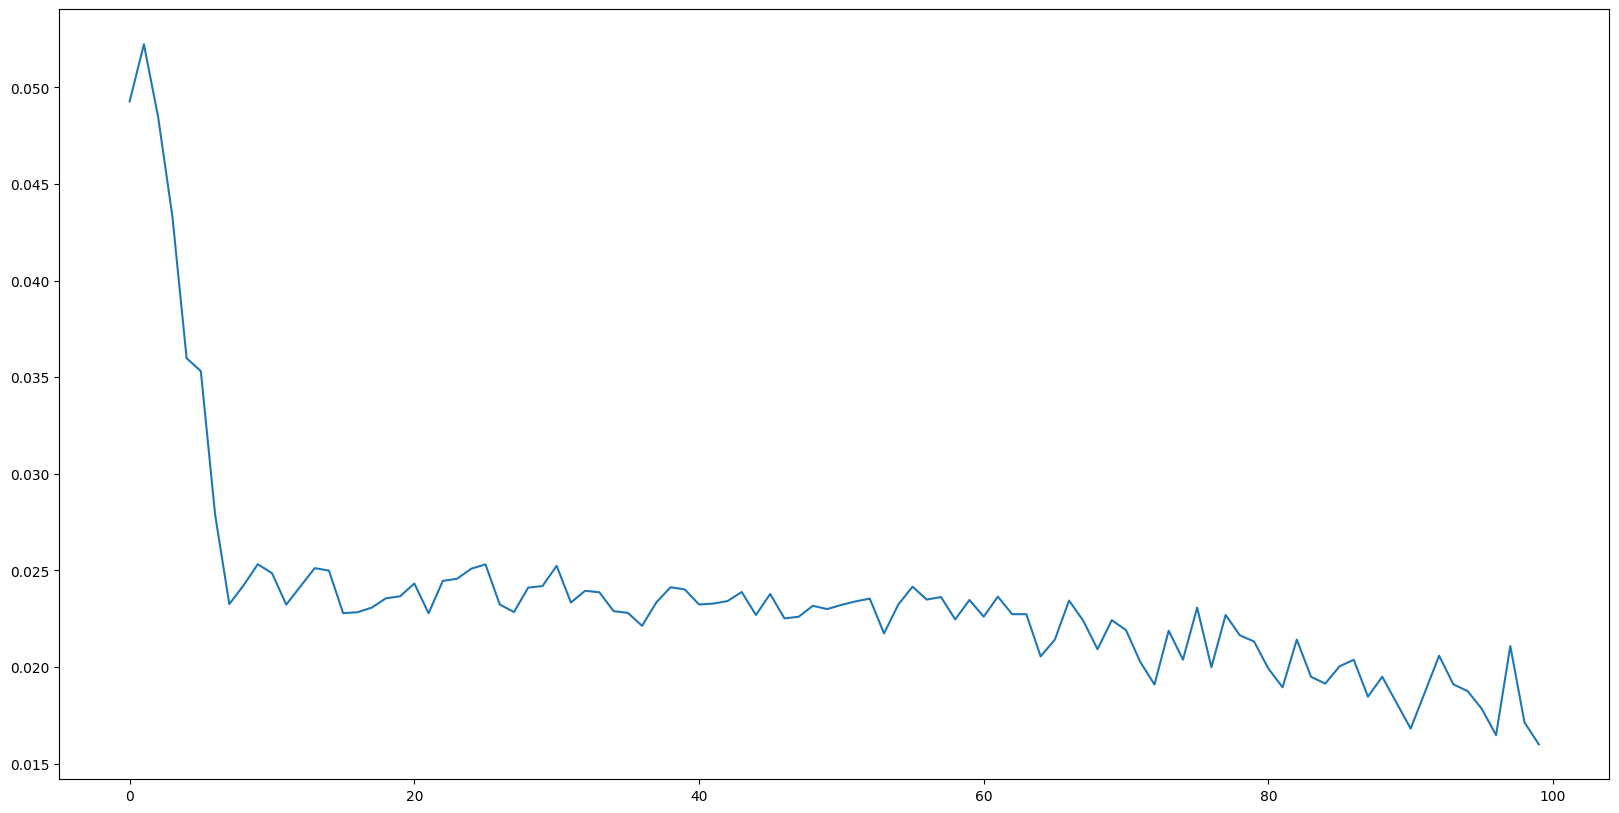

In [40]:
plt.figure(figsize=(20,10))
plt.plot(maml.meta_losses)

In [21]:
def loss_on_random_task(initial_model, K, num_steps, optim=torch.optim.Adam):
    """
    trains the model on a random sine task and measures the loss curve.
    
    for each n in num_steps_measured, records the model function after n gradient updates.
    """
    
    # copy MAML model into a new object to preserve MAML weights during training
    model = MAMLModel(input_size=INPUT_SIZE, 
                   hidden_size=HIDDEN_SIZE, 
                   seq_len=SEQ_LEN, 
                   num_layers=NUM_LAYERS,
                   num_classes=NUM_CLASSES, 
                   device=device).to(device)
    
    model.load_state_dict(initial_model.state_dict())
    criterion = CRITERION
    optimiser = optim(model.parameters(), 0.01)
    X = pl[["Realized_Power"]].values
    y = pl["Real_block"].values
    losses = []    
    
    # train model on a random task
    for epoch in range(1, num_steps+1): # epoch
        seq, target = sample_data(X, y, SEQ_LEN, K)

        out = model(seq)
        loss = criterion(out, target) / K # y - y_label
        losses.append(loss.item())

        model.zero_grad()
        loss.backward()
        optimiser.step()
            
    return losses

In [22]:
def average_losses(initial_model, n_samples, K=10, n_steps=10, optim=torch.optim.Adam):
    """
    returns the average learning trajectory of the model trained for ``n_iterations`` over ``n_samples`` tasks
    """
    
    x = np.linspace(-5, 5, 2) # dummy input for test_on_new_task
    avg_losses = [0] * K
    for i in range(n_samples):
        losses = loss_on_random_task(initial_model, K, n_steps, optim)
        avg_losses = [l + l_new for l, l_new in zip(avg_losses, losses)]
    avg_losses = [l / n_samples for l in avg_losses]
    
    return avg_losses

In [23]:
def mixed_pretrained(iterations=500, K=10):
    """
    returns a model pretrained on a selection of ``iterations`` random tasks.
    """
    
    # set up model
    pretrain_model = MAMLModel(input_size=INPUT_SIZE, 
                   hidden_size=HIDDEN_SIZE, 
                   seq_len=SEQ_LEN, 
                   num_layers=NUM_LAYERS,
                   num_classes=NUM_CLASSES, 
                   device=device).to(device)
    
    optimiser = torch.optim.Adam(pretrain_model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    X = pl[["Realized_Power"]].values
    y = pl["Real_block"].values

    # fit the model
    for i in range(iterations):
        seq, target = sample_data(X, y, SEQ_LEN, K)
        out = pretrain_model(seq)
        #print(seq, target) = feature, label
        loss = criterion(out, target) 
        pretrain_model.zero_grad()
        loss.backward()
        optimiser.step()
        
    return pretrain_model

In [24]:
pretrained_model = mixed_pretrained(100, 10).to(device)

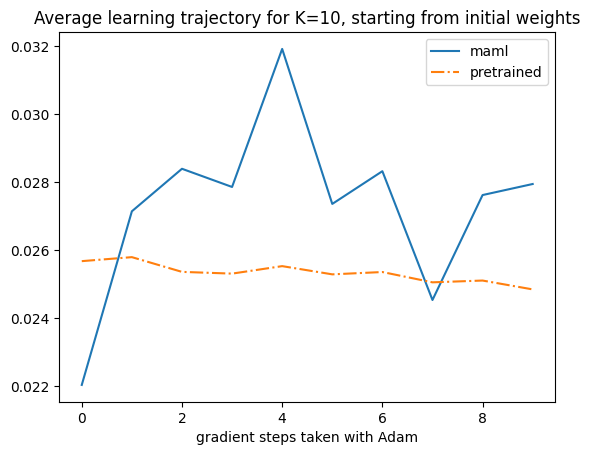

In [23]:
plt.plot(average_losses(maml.model, n_samples=100, K=10), label='maml')
plt.plot(average_losses(pretrained_model, n_samples=100, K=10),'-.', label='pretrained')
plt.legend()
plt.title("Average learning trajectory for K=10, starting from initial weights")
plt.xlabel("gradient steps taken with Adam")
plt.show()

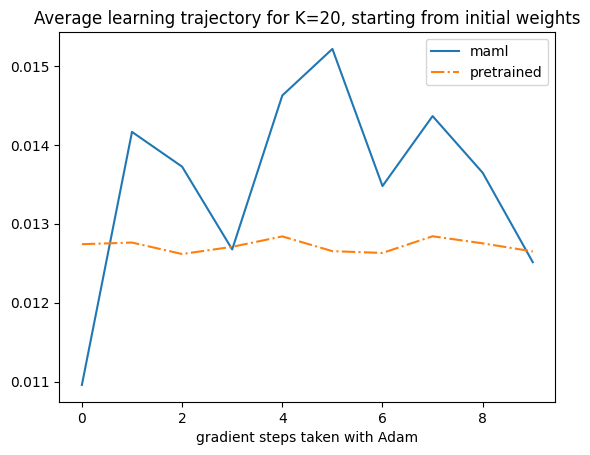

In [24]:
plt.plot(average_losses(maml.model, n_samples=100, K=20), label='maml')
plt.plot(average_losses(pretrained_model, n_samples=100, K=20),'-.', label='pretrained')
plt.legend()
plt.title("Average learning trajectory for K=20, starting from initial weights")
plt.xlabel("gradient steps taken with Adam")
plt.show()

In [25]:
def model_functions_at_training(initial_model, X, y, sampled_steps, optim=torch.optim.Adam, lr=0.01):
    """
    trains the model on X, y and measures the loss curve.
    
    for each n in sampled_steps, records model(x_axis) after n gradient updates.
    """
    
    # copy MAML model into a new object to preserve MAML weights during training
    
    model = MAMLModel(input_size=INPUT_SIZE, 
                   hidden_size=HIDDEN_SIZE, 
                   seq_len=SEQ_LEN, 
                   num_layers=NUM_LAYERS,
                   num_classes=NUM_CLASSES, 
                   device=device).to(device)

    model.load_state_dict(initial_model.state_dict())
    criterion = CRITERION
    optimiser = optim(model.parameters(), lr)

    # train model on a random task
    num_steps = max(sampled_steps)
    K = X.shape[0]
    
    losses = []
    outputs = {}

    for step in range(1, num_steps+1):
        loss = criterion(model(X), y) / K
        losses.append(loss.item())

        # compute grad and update inner loop weights
        model.zero_grad()
        loss.backward()
        optimiser.step()

        # plot the model function
        if step in sampled_steps:
            outputs[step] = model(torch.tensor(X, dtype=torch.float)).cpu().detach().numpy()
            
    outputs['initial'] = initial_model(torch.tensor(X, dtype=torch.float)).cpu().detach().numpy()
    
    return outputs, losses

In [26]:
def plot_sampled_performance(initial_model, model_name, X, y, K, optim=torch.optim.Adam, lr=0.01):
    
    sampled_steps=[1,10]
    outputs, losses = model_functions_at_training(initial_model, 
                                                  X, y, 
                                                  sampled_steps=sampled_steps,
                                                  optim=optim, 
                                                  lr=lr)

    plt.figure(figsize=(15,5))
    x_axis = np.linspace(0, K-1, K)
    # plot the model functions
    plt.subplot(1, 2, 1)
    
    plt.plot(y.cpu(), '-', color=(0, 0, 1, 0.5), label='true function')
    plt.scatter(x_axis, y.cpu(), label='data')
    
    for step in sampled_steps:
        if step == 1:
            plt.plot(outputs[step], '-.', color=(0.5, 0, 0, 1),
                    label='model after {} steps'.format(step))
        elif step == 10:
            plt.plot(outputs[step], '*-', color=(0.5, 0, 0, 1),
                 label='model after {} steps'.format(step))

    plt.legend(loc='lower right')
    plt.title("Model fit: {}".format(model_name))

    # plot losses
    plt.subplot(1, 2, 2)
    plt.plot(losses)
    plt.title("Loss over time")
    plt.xlabel("gradient steps taken")
    plt.show()

C:\Users\DCLAB\AppData\Local\Temp\ipykernel_30568\1361310019.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs[step] = model(torch.tensor(X, dtype=torch.float)).cpu().detach().numpy()
C:\Users\DCLAB\AppData\Local\Temp\ipykernel_30568\1361310019.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial'] = initial_model(torch.tensor(X, dtype=torch.float)).cpu().detach().numpy()


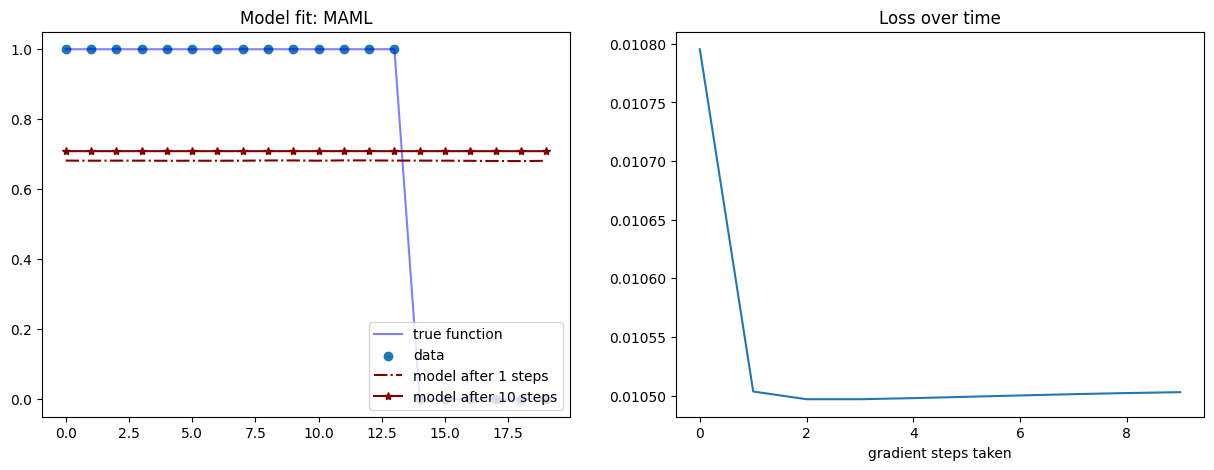

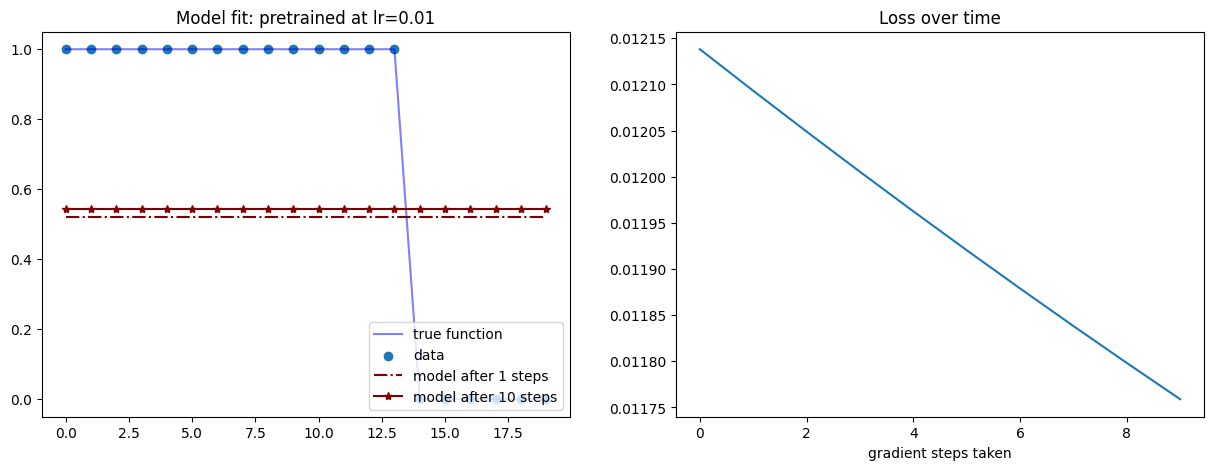

In [39]:
K = 20

X = pl[["Realized_Power"]].values
y = pl["Real_block"].values
seq, target = sample_data(X, y, SEQ_LEN, K)

plot_sampled_performance(maml.model, 'MAML', seq, target, K)
plot_sampled_performance(pretrained_model, 'pretrained at lr=0.01', seq, target, K)

C:\Users\DCLAB\AppData\Local\Temp\ipykernel_30568\1361310019.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs[step] = model(torch.tensor(X, dtype=torch.float)).cpu().detach().numpy()
C:\Users\DCLAB\AppData\Local\Temp\ipykernel_30568\1361310019.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial'] = initial_model(torch.tensor(X, dtype=torch.float)).cpu().detach().numpy()


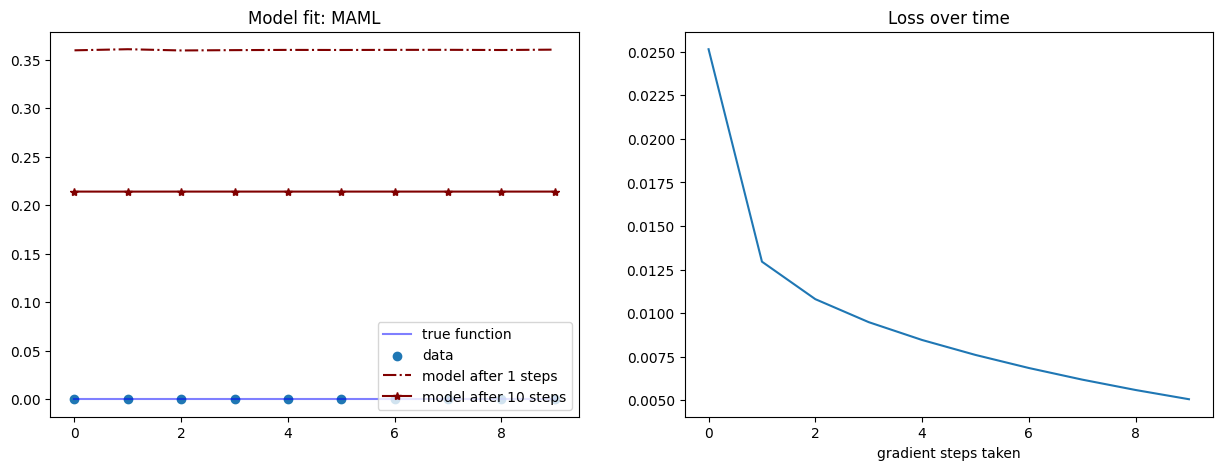

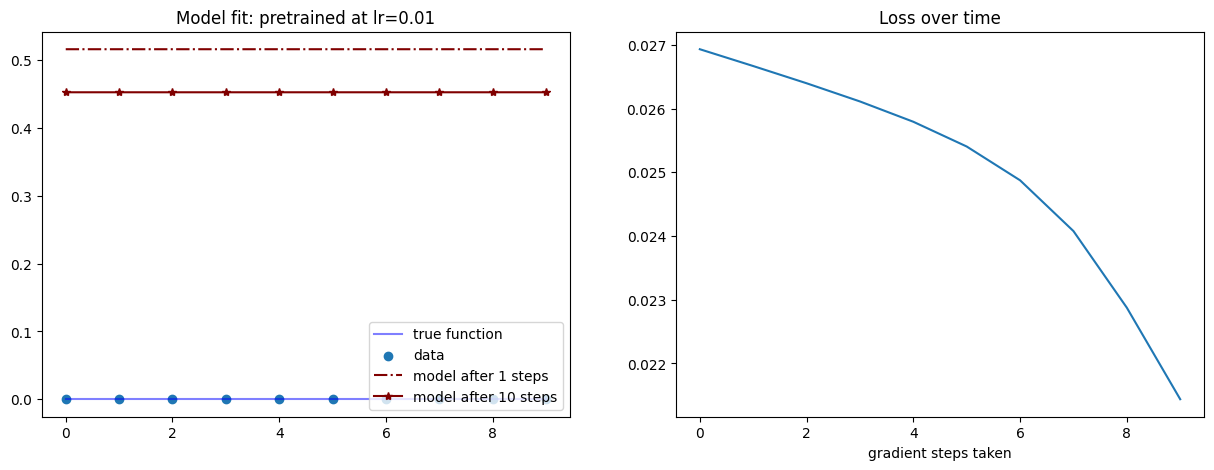

In [38]:
K = 10

X = pl[["Realized_Power"]].values
y = pl["Real_block"].values
seq, target = sample_data(X, y, SEQ_LEN, K)

plot_sampled_performance(maml.model, 'MAML', seq, target, K)
plot_sampled_performance(pretrained_model, 'pretrained at lr=0.01', seq, target, K)

In [27]:
X = pl[["Realized_Power"]].values
y = pl["Real_block"].values

In [28]:
train_loader, test_loader = train_test_seperate(X, y, SEQ_LEN, SPLIT ,BATCH_SIZE)

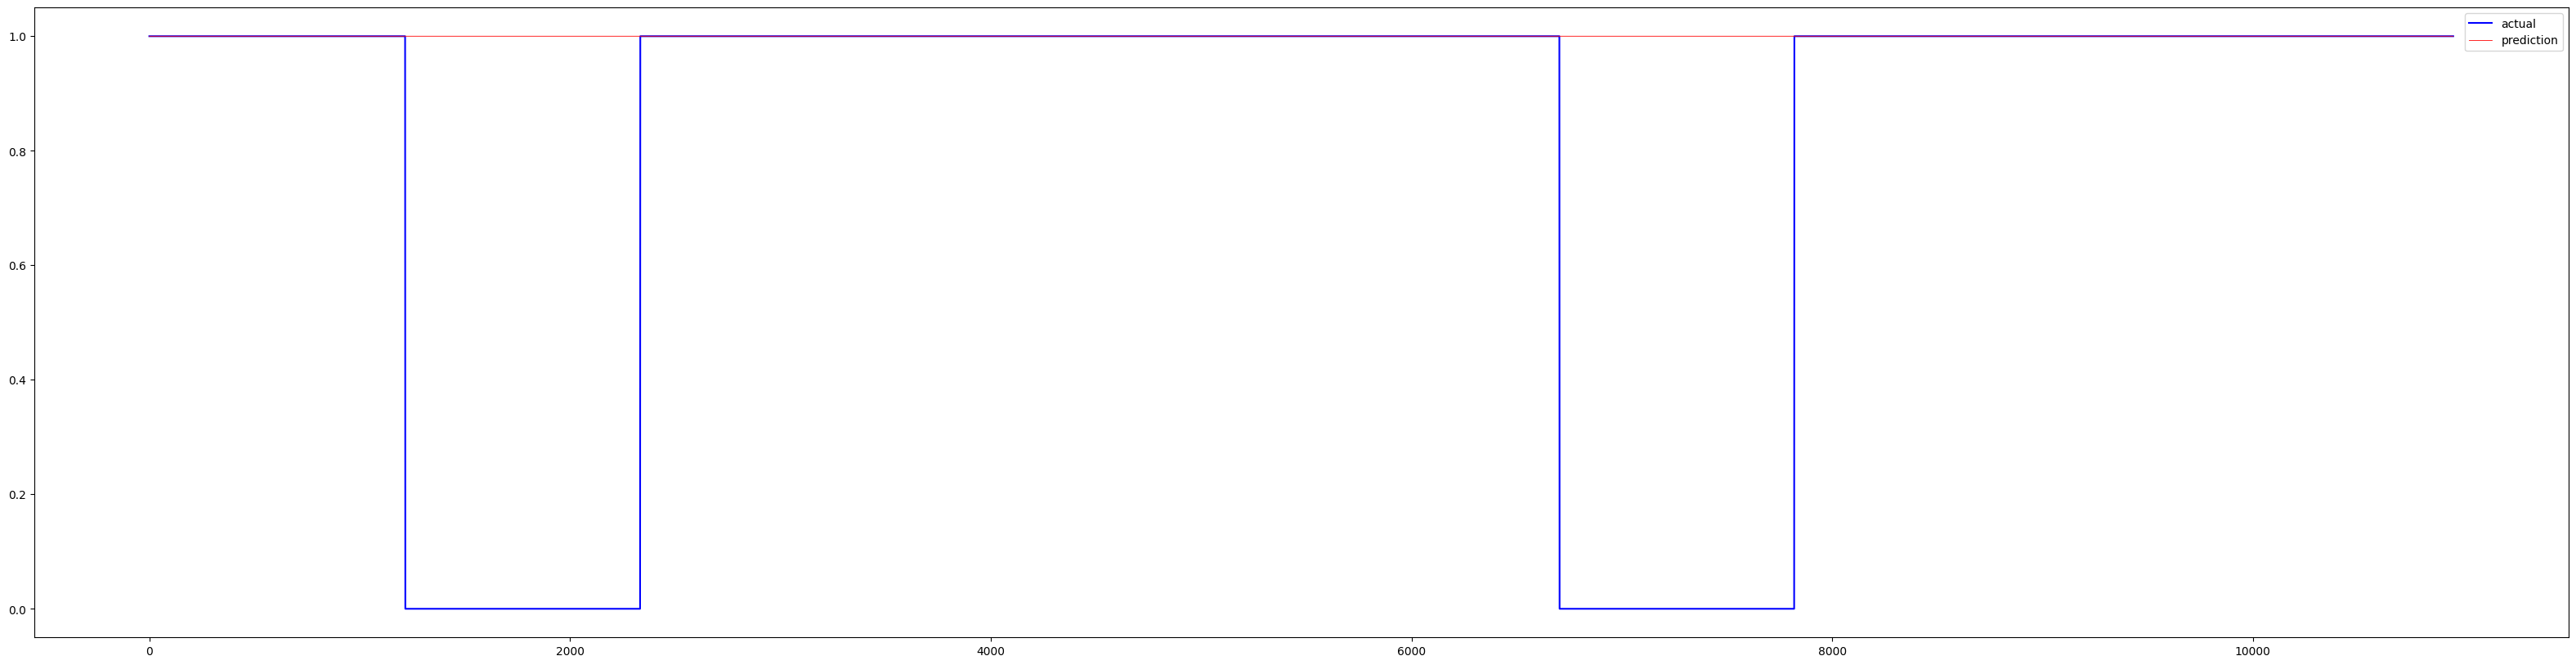

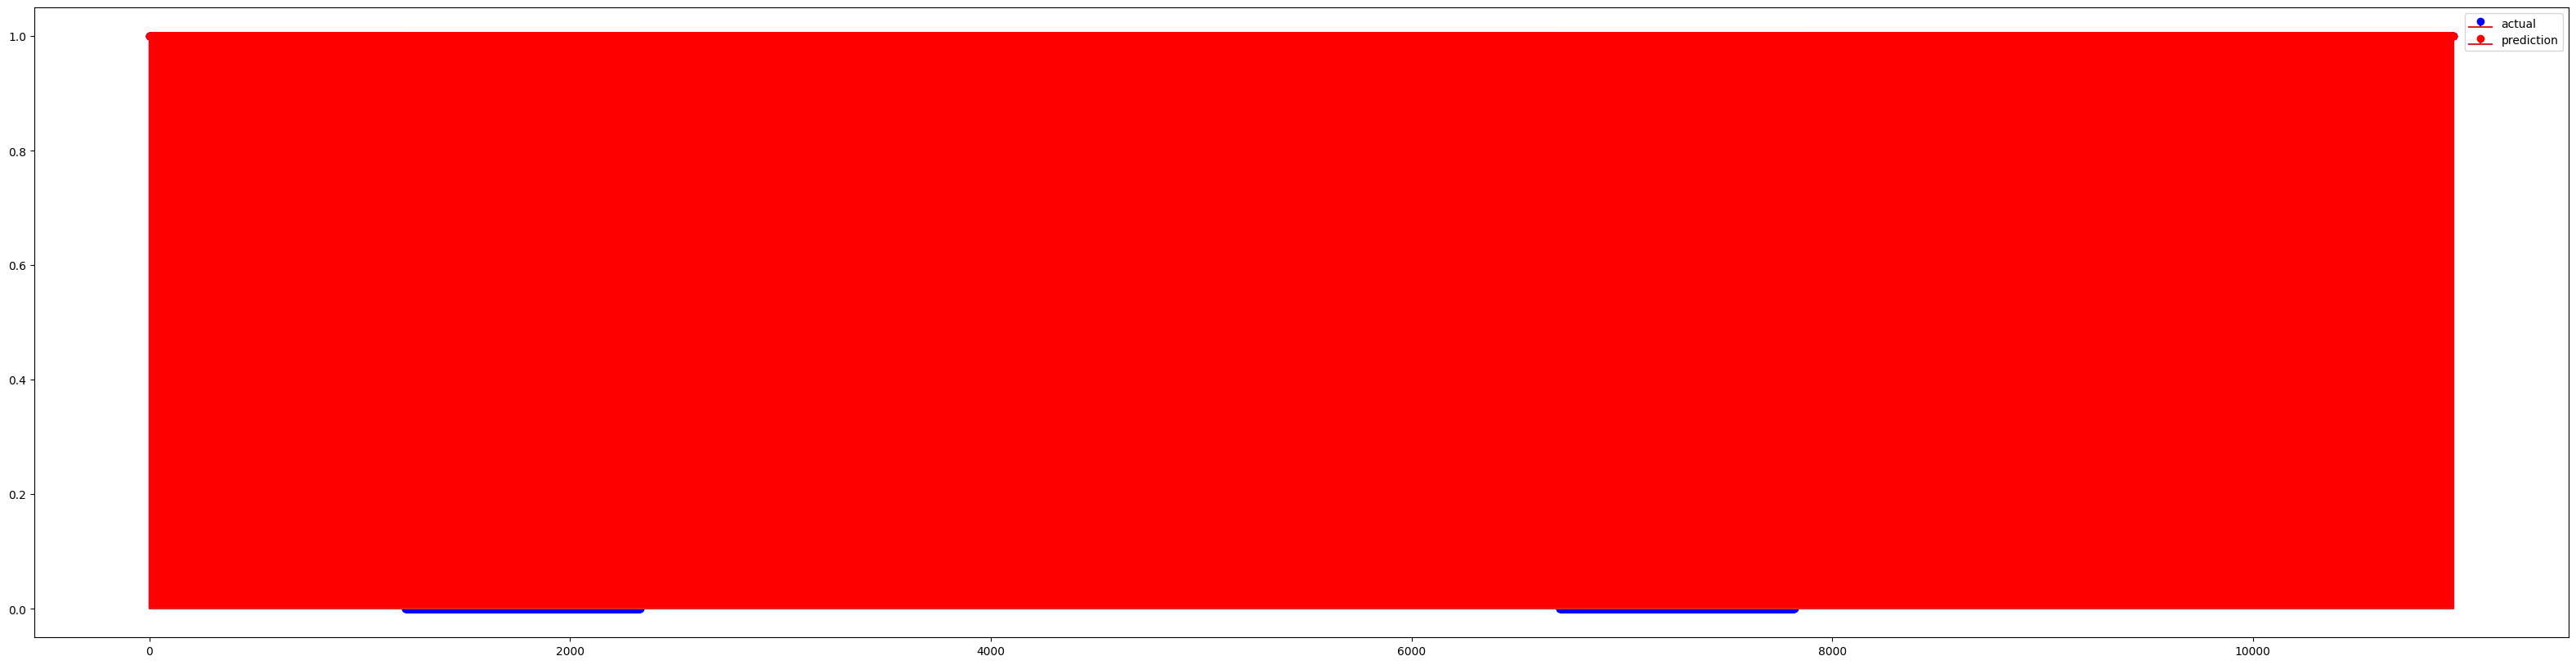


----------------------------------------------
the number of correct 8720
the number of uncorrect 2233

confusion matrix
TP: 8720
TN: 0
FP: 2233
FN: 0

accuracy: 0.7961289144526613


In [48]:
K = 10

losses = []
n = len(test_loader)

with torch.no_grad():
    test_pred = []
    for data in test_loader:
        seq, target = data # batch data 
        out = model(seq)
        test_pred += out.cpu().numpy().round().tolist()

    actual = target
    total = test_pred       
    
    #plot
    plt.figure(figsize=(40,10))
    
    #signal
    plt.plot(actual[:].cpu().numpy(),'b')
    plt.plot(total[:],'r', linewidth=0.6)
    plt.legend(['actual','prediction'])
    plt.show()

    #stem
    plt.figure(figsize=(40,10))
    plt.stem(actual[:].cpu().numpy(),'b')
    plt.stem(total[:],'r')
    plt.legend(['actual','prediction']) 
    plt.show()

    t=np.array(actual[:].cpu().numpy())
    l=np.array(total[:])
    
    correct=0
    uncorrect=0
    FP=0;TP=0;FN=0;TN=0
    
    for i, j in zip(t, l):
        if(i-j==0):
            correct=correct+1
            if(j==1):TP=TP+1
            else:TN=TN+1
        else: 
            uncorrect=uncorrect+1
            if(j==1):FP=FP+1
            else:FN=FN+1
    
    all=correct+uncorrect
    acc=correct/all
    
    #accuracy (classification)
    print("\n----------------------------------------------")
    print('the number of correct', correct)
    print('the number of uncorrect', uncorrect)

    print("\n"+"confusion matrix")
    print("TP: "+str(TP))
    print("TN: "+str(TN))
    print("FP: "+str(FP)) 
    print("FN: "+str(FN))

    print('\n'+'accuracy:', acc)

